# Bias correct CESM2 wind speeds to ERA5 using stress

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import sys
import cmocean
sys.path.append('/home/users/birgal/')
from nemo_python_git.utils import fix_lon_range

Equation: 

$\tau = \rho C_D U_z |U_z| = \rho C_d U^2 = \rho C_d (u^2 + v^2)$ OR

$ \tau_x = \rho \cdot C_d \cdot u \cdot  \sqrt{u^2 + v^2}$

$ \tau_y = \rho \cdot C_d \cdot v \cdot \sqrt{u^2 + v^2}$

Write out sea ice ($C_{di}$) and ocean ($C_{do}$) drag coefficients and calculate:

$\tau_{ERA5} = \tau_{CESM2}$

$(C_{di ERA5} + C_{do ERA5}) (u_{ERA5}^2 + v_{ERA5}^2) = (C_{di CESM2} + C_{do CESM2}) (u_{CESM2}^2 + v_{CESM2}^2 + bias)$

$\frac{C_{di ERA5} + C_{do ERA5}}{C_{di CESM2} + C_{do CESM2}} (u_{ERA5}^2 + v_{ERA5}^2) = u_{CESM2}^2 + v_{CESM2}^2 + bias$

$bias = \frac{C_{di ERA5} + C_{do ERA5}}{C_{di CESM2} + C_{do CESM2}} (u_{ERA5}^2 + v_{ERA5}^2) - u_{CESM2}^2 - v_{CESM2}^2$

Or alternatively, I could read in wind stress from ERA5 forced experiment and from CESM2 forced experiment: utau_oce, vtau_oce (taum is already written to file)

$C_D$ --- bulk transfer coefficient of momentum


Steps:
- Mean surface air density for ERA5 and CESM2 experiments
- Mean of ERA5 u10 and v10 over the timeseries
- Ensemble mean of CESM2 U and V over the timeseries
- Regrid ERA5 and CESM2 velocities onto the NEMO grid
- Drag coefficients for an experiment with ERA5 and for an experiment with CESM2

OR
- Mean of ERA5 experiment taum
- Mean of CESM2 experiment taum
- Stress bias = difference between these two
- Then, $stress bias = \rho_{air} C_D (u^2 + v^2 + wind bias)$ $\rightarrow$ $wind bias = \frac{stress bias}{\rho_o C_D} - u^2 - v^2$

In [2]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
# cesm2_u = xr.open_dataset(f'{base_dir}climate-forcing/CESM2/LE2/processed/CESM2-LE2_ens1011.001_UBOT_y1979.nc').mean(dim='time')
# cesm2_v = xr.open_dataset(f'{base_dir}climate-forcing/CESM2/LE2/processed/CESM2-LE2_ens1011.001_VBOT_y1979.nc').mean(dim='time')
# cesm2_u10 = xr.open_dataset(f'{base_dir}climate-forcing/CESM2/LE2/processed/CESM2-LE2_ens1011.001_U10x_y1979.nc').mean(dim='time')
# cesm2_v10 = xr.open_dataset(f'{base_dir}climate-forcing/CESM2/LE2/processed/CESM2-LE2_ens1011.001_U10y_y1979.nc').mean(dim='time')
# era5_u  = xr.open_dataset(f'{base_dir}ERA5-forcing/daily/files/processed/u10_time_y1979.nc').mean(dim='time')
# era5_v  = xr.open_dataset(f'{base_dir}ERA5-forcing/daily/files/processed/v10_time_y1979.nc').mean(dim='time')

# era5_ds  = xr.open_dataset(f'{base_dir}output/ERA5_test10_writedrag/files0/eANT025.L121_1m_19790101_19791231_SBC.nc').mean(dim='time_counter')
nemo_mask = xr.open_dataset(f'{base_dir}bathymetry/mesh_mask-20240305.nc').squeeze()
land_mask = nemo_mask.tmask.isel(nav_lev=0).rename({'x':'x_grid_T', 'y':'y_grid_T'}) 

cesm2era5 = xr.open_dataset(f'{base_dir}output/CESM2_hist8/files0/eANT025.L121_1m_19790101_19791231_SBC.nc').mean(dim='time_counter')
cesm2u10  = xr.open_dataset(f'{base_dir}output/CESM2_hist7/files0/eANT025.L121_1m_19790101_19791231_SBC.nc').mean(dim='time_counter')
cesm2_ds  = xr.open_dataset(f'{base_dir}output/CESM2_hist6_writedrag/files0/eANT025.L121_1m_19790101_19791231_SBC.nc').mean(dim='time_counter')
# cesm2_ds2 = xr.open_dataset(f'{base_dir}output/CESM2_hist6_writedrag/files0/eANT025.L121_1m_19800101_19801231_SBC.nc').mean(dim='time_counter')

In [66]:
def compare_variable(ds1, ds2, varname, vmin=None, vmax=None, ylim=(None,None), title1='', title2='', title3='Panel 1 - Panel 2'):
    kwags = {'vmin':vmin, 'vmax':vmax, 'ylim':ylim}
    
    fig, ax = plt.subplots(1,3, figsize=(20,4))
    ds1[varname].where(land_mask!=0).plot(ax=ax[0], **kwags)
    ds2[varname].where(land_mask!=0).plot(ax=ax[1], **kwags)
    (ds1[varname] - ds2[varname]).where(land_mask!=0).plot(ax=ax[2], cmap=cmocean.cm.balance, ylim=(50,None), vmin=-3, vmax=3)
    ax[0].set_title(title1); ax[1].set_title(title2); ax[2].set_title(title3);
    
    return fig, ax 

## Let's instead try just scaling the wind with a scalar magnitude.
- air density differences don't change strongly year-to-year (~0.02 on values ranging from 1.25-1.35). Ocean drag changes by ~5e-5 for values between 1.0e-3 to 1.6e-3, so interannual variation is less than the spatial variation within a year. But, could there still be significant drift over time? A bit hard to know what to do about all of that. 
- 

In [ ]:
# instead of looking at the output wind speeds, compare the actual forcing for these analyses (will involve regridding both to the eANT025 grid)

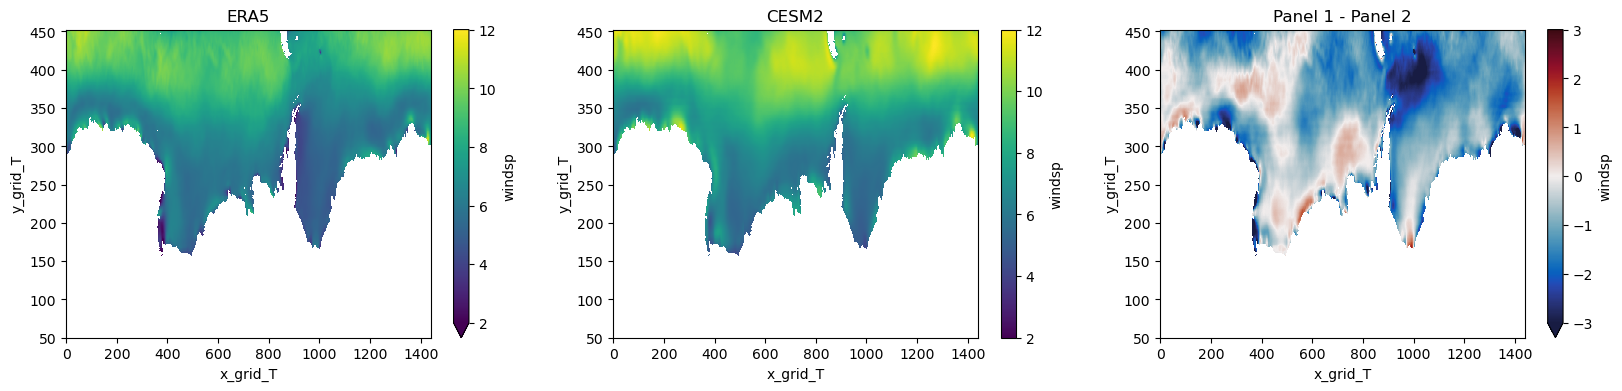

In [88]:
fig, ax = compare_variable(cesm2era5, cesm2u10, 'windsp', vmin=2, vmax=12, ylim=(50,None), title1='ERA5', title2='CESM2')

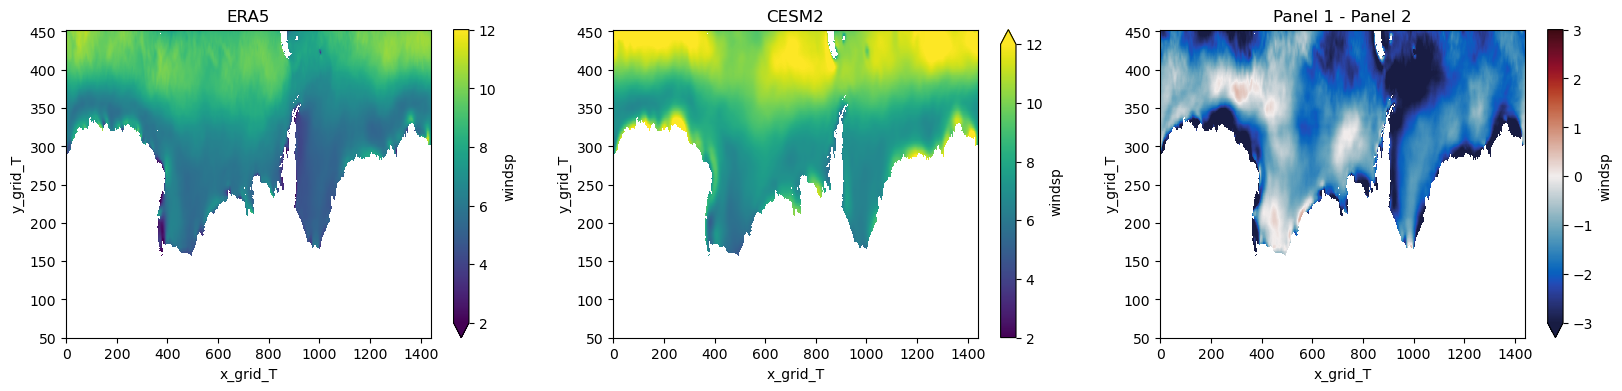

In [34]:
fig, ax = compare_variable(cesm2era5, cesm2_ds, 'windsp', vmin=2, vmax=12, ylim=(50,None), title1='ERA5', title2='CESM2')

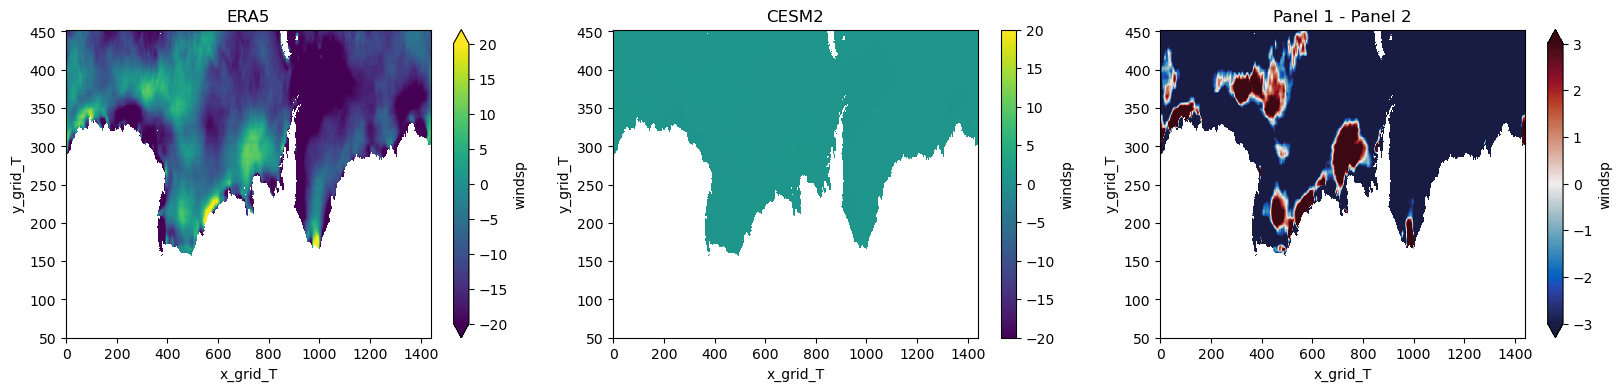

In [73]:
# fraction of wind speeds that are off.
fig, ax = compare_variable((cesm2era5 - cesm2u10)*100/cesm2u10, cesm2era5/cesm2u10, 'windsp', vmin=-20, vmax=20, ylim=(50,None), title1='ERA5', title2='CESM2')

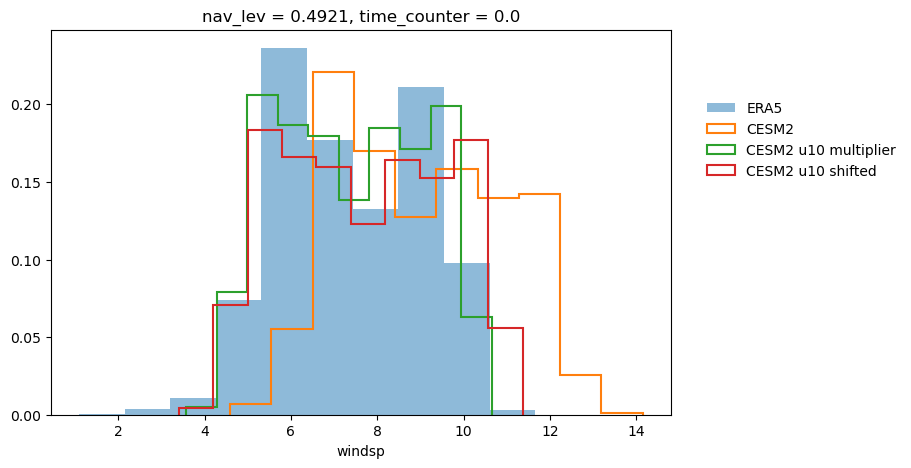

In [20]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
kwags1={'density':True, 'histtype':'step', 'ax':ax, 'lw':1.5}
kwags2={'density':True, 'ax':ax, 'alpha':0.5}
cesm2era5.windsp.where(land_mask!=0).plot.hist(label='ERA5', **kwags2)
cesm2_ds.windsp.where(land_mask!=0).plot.hist(label='CESM2', **kwags1)
# (cesm2u10.windsp).where(land_mask!=0).plot.hist(label='CESM2 u10', **kwags1)
(cesm2u10.windsp*0.89).where(land_mask!=0).plot.hist(label='CESM2 u10 multiplier', **kwags1)
(cesm2u10.windsp - 0.6).where(land_mask!=0).plot.hist(label='CESM2 u10 shifted', **kwags1)
ax.legend(loc=(1.05, 0.6), frameon=False)

In [60]:
cesm2_wind = cesm2_ds.windsp.where(land_mask!=0)
cesm2_wind_u10 = cesm2u10.windsp.where(land_mask!=0)
era5_wind  = cesm2era5.windsp.where(land_mask!=0)

wind_rms_u10 = np.sqrt((era5_wind - cesm2_wind_u10)**2)
wind_rms = np.sqrt((era5_wind - cesm2_wind)**2)
wind_rms_multiple = np.sqrt((era5_wind - 0.89*cesm2_wind)**2)
wind_rms_u10_multiple = np.sqrt((era5_wind - 0.89*cesm2_wind_u10)**2)
wind_rms_shifted = np.sqrt((era5_wind - (cesm2_wind - 0.6))**2)
wind_rms_u10_shifted = np.sqrt((era5_wind - (cesm2_wind_u10 - 0.6))**2)
# wind_rms_spatial  = np.sqrt((era5_wind - spatial_diff*cesm2_wind)**2)

minimize rms of spacial field --- check whether a constant multiplier would work or a spatially varying one. 
Plus whether it should be a multiplier versus and offset.

Text(0.5, 0, 'Wind speed RMSE')

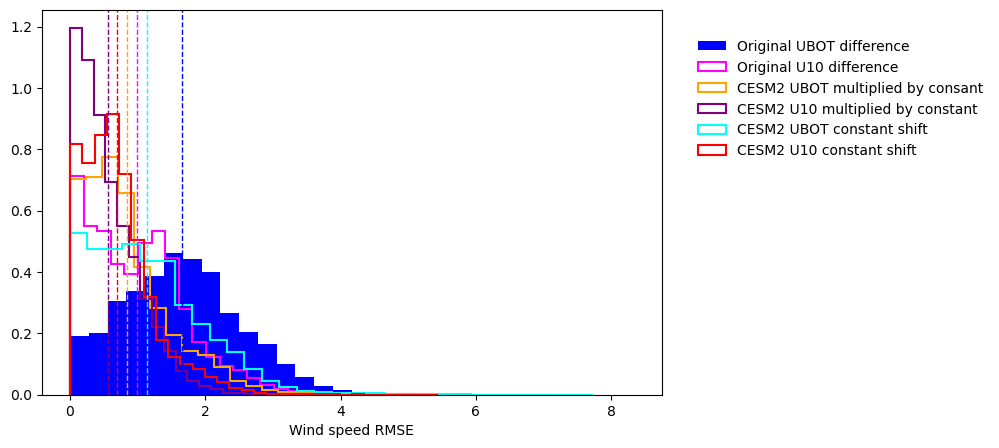

In [64]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
kwags1={'density':True, 'histtype':'step', 'lw':1.5, 'ax':ax, 'bins':30}
wind_rms.plot.hist(bins=30, ax=ax, color='blue', density=True, label='Original UBOT difference')
wind_rms_u10.plot.hist(color='magenta', label='Original U10 difference', **kwags1)

wind_rms_multiple.plot.hist(label='CESM2 UBOT multiplied by consant', color='orange', **kwags1)
wind_rms_u10_multiple.plot.hist(color='purple', label='CESM2 U10 multiplied by constant', **kwags1)

wind_rms_shifted.plot.hist(label='CESM2 UBOT constant shift', color='cyan', **kwags1)
wind_rms_u10_shifted.plot.hist(label='CESM2 U10 constant shift', color='red', **kwags1)
# wind_rms_multiple.plot.hist(label='CESM2 u10 spatially varying multiplier', color='magenta', **kwags1)

plt.axvline(wind_rms.mean(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(wind_rms_u10.mean(), color='magenta', linestyle='dashed', linewidth=1)
plt.axvline(wind_rms_multiple.mean(), color='orange', linestyle='dashed', linewidth=1)
plt.axvline(wind_rms_u10_multiple.mean(), color='purple', linestyle='dashed', linewidth=1)
plt.axvline(wind_rms_shifted.mean(), color='cyan', linestyle='dashed', linewidth=1)
plt.axvline(wind_rms_u10_shifted.mean(), color='red', linestyle='dashed', linewidth=1)
ax.legend(loc=(1.05, 0.6), frameon=False)
ax.set_title('')
ax.set_xlabel('Wind speed RMSE')